<font size="5">Stable Diffusion Inference </font> 
<br>
This notebook performs the following steps:<br>
* How to generate novel images based on a text prompt using the KerasCV implementation <br>
* Enable FP16 precision for faster inference <br>
* Use of ITEX[GPU] <br>

In [1]:
import time
from keras_cv.models.stable_diffusion import StableDiffusion
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

2023-05-02 13:09:59.581814: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:09:59.712903: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 13:09:59.716527: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/tbb/2021.9.0/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.


/home/nazneen/.conda/envs/kerascv-patch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_images(images):
    png_name = "{}_{}imgs_{}steps.png".format(
        precision, batch_size, num_steps)
    
    print("Start plotting the generated images to %s" % (png_name))
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

<font size ="4">First, we construct a model and define few of the required parameters:</font>

In [3]:
iterations = 2
use_xla = False
precision = 'fp32'
batch_size = 1
num_steps = 50
seed= 123
benchmark_result = []

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,
    precision=precision,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


<font size ="4">Next, we give it a prompt: </font>

Start Warmup


2023-05-02 13:10:16.427930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 13:10:16.429511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform XPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 13:10:16.429528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform XPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 13:10:16.429556: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-02 13:10:36.153945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


50/50 [==============================] - 53s 470ms/step


2023-05-02 13:11:16.723798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


Start running inference and generating images
50/50 [==============================] - 24s 471ms/step
FP32 precision: 24.01 seconds
Start plotting the generated images to fp32_1imgs_50steps.png


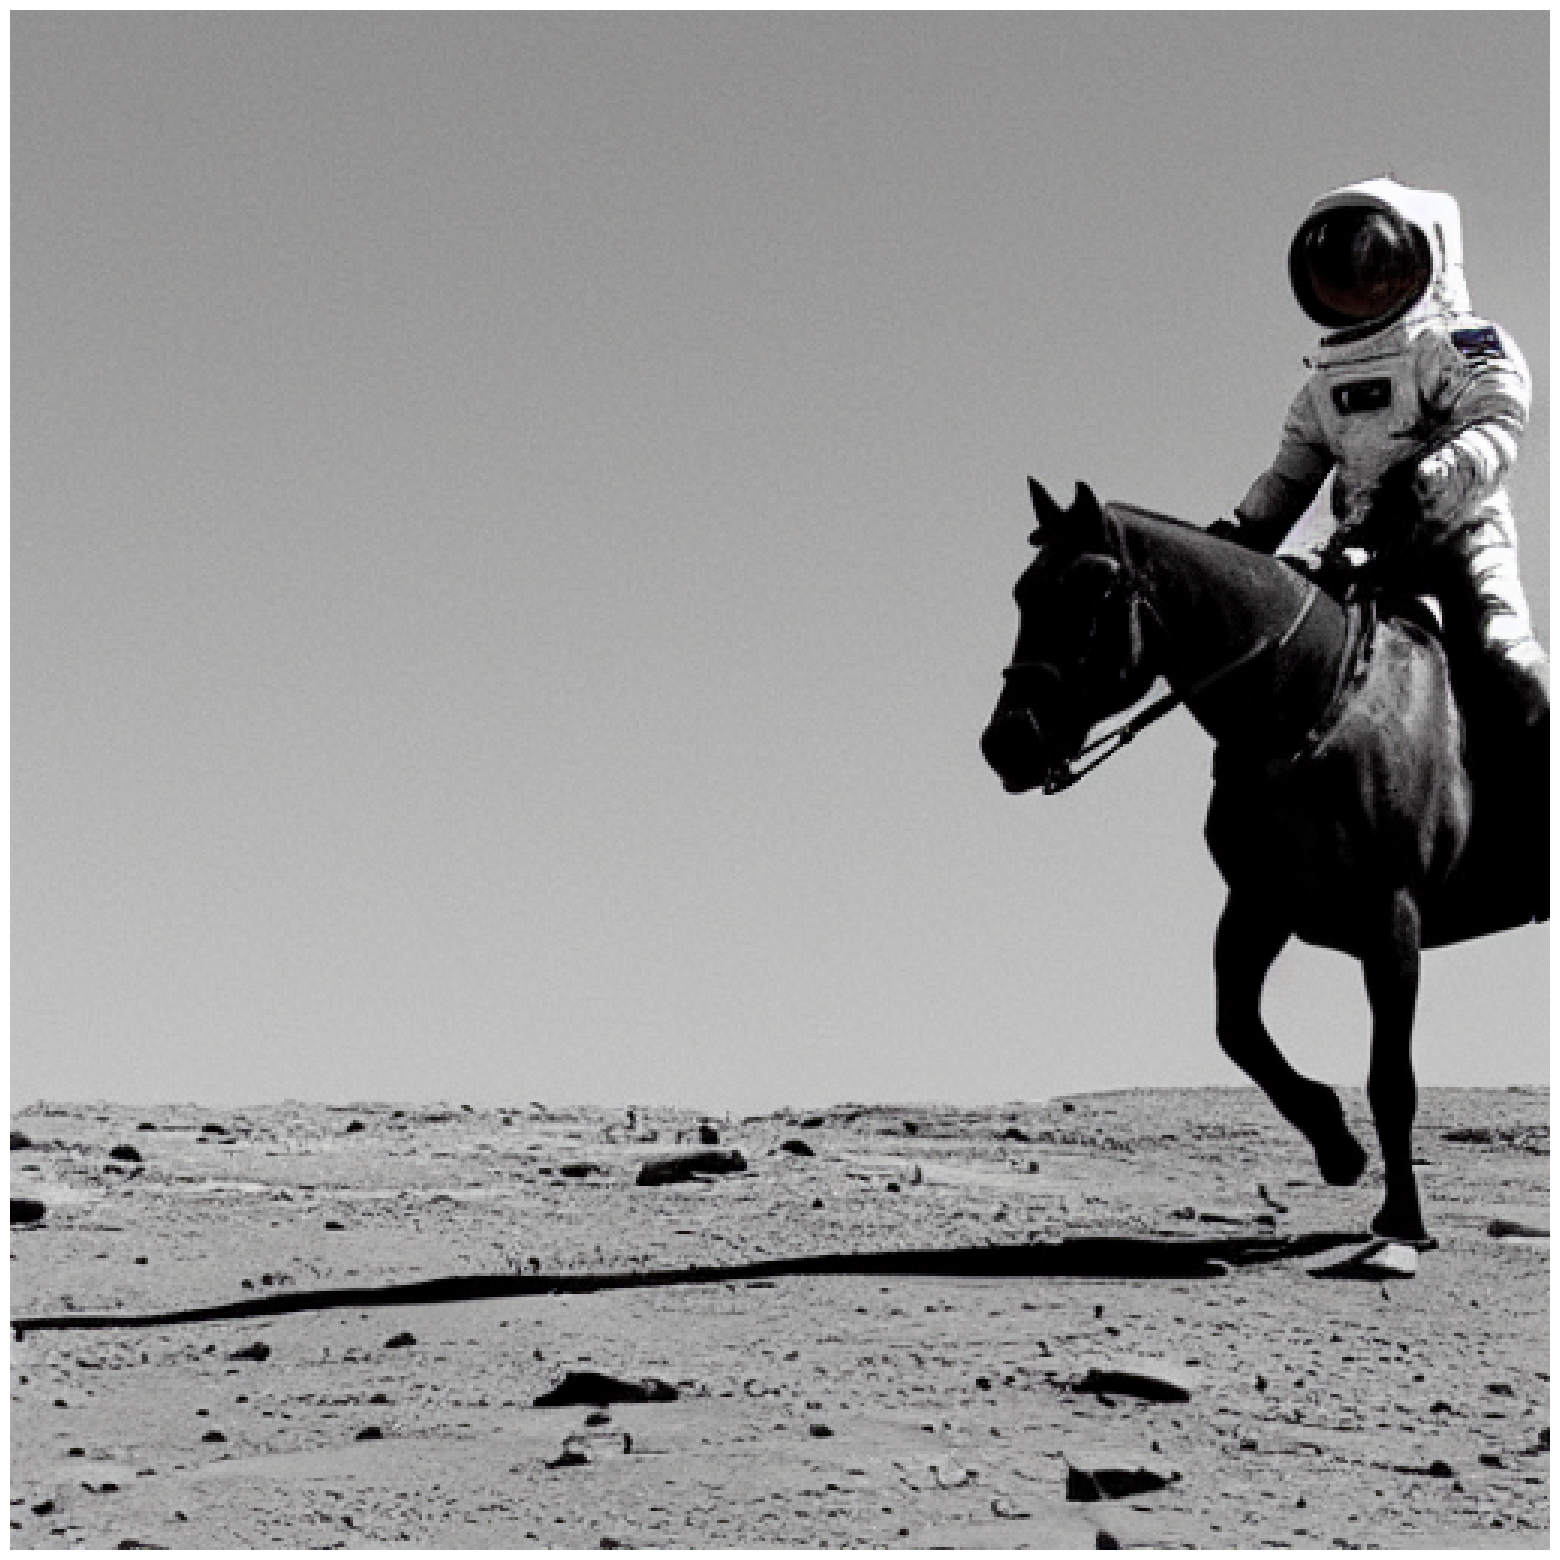

In [4]:
prompt = "a photo of an astronaut riding a horse on mars"

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed)
    t+=(time.time() - start_time)
print(f"FP32 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["Standard FP32 precision", t/iterations])
plot_images(images)

<font size="4">Performance computation using float16 precision </font>
<br>
We optimized official keras-cv Stable Diffusion to add fp16 mode for model.</font>

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
Start Warmup


2023-05-02 13:13:14.847796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.
2023-05-02 13:13:32.949056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


50/50 [==============================] - 48s 286ms/step


2023-05-02 13:14:06.718240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type XPU is enabled.


Start running inference and generating images
50/50 [==============================] - 14s 287ms/step
FP16 precision: 14.64 seconds
Start plotting the generated images to fp16_1imgs_50steps.png


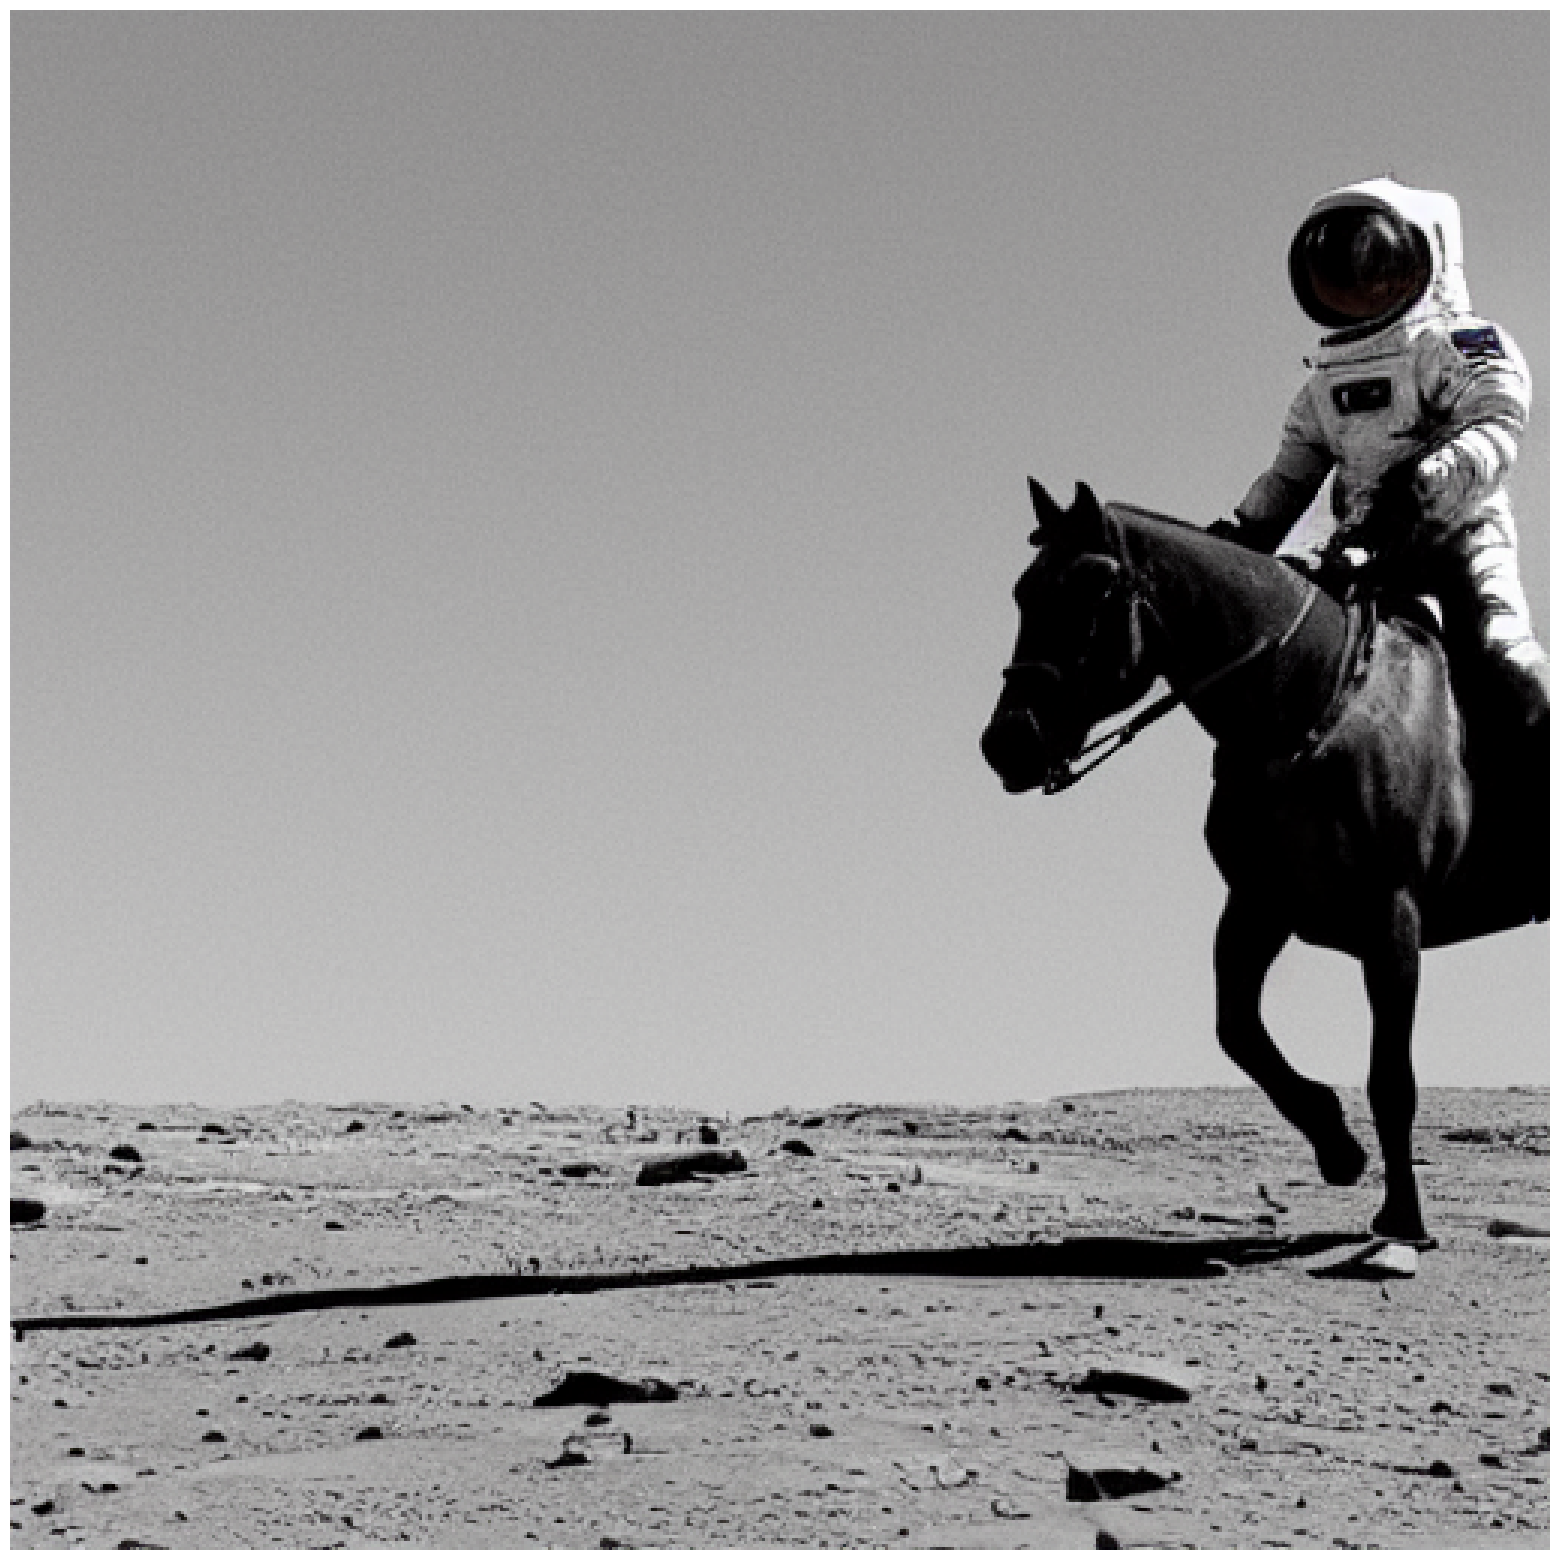

In [6]:
precision = 'fp16'

model = StableDiffusion(
    img_width=512,
    img_height=512,
    jit_compile=use_xla,
    precision=precision,
)

print("Start Warmup")
model.text_to_image(
    "warming up the model", batch_size=batch_size, num_steps=num_steps
)
# Start inference
print("Start running inference and generating images")
t = 0
for i in range(iterations):
    start_time = time.time()
    images = model.text_to_image(prompt=prompt, batch_size=batch_size, seed=seed)
    t+=(time.time() - start_time)
    
print(f"FP16 precision: {(t/iterations):.2f} seconds")
benchmark_result.append(["FP16 precision", t/iterations])
plot_images(images)

In [9]:
print("{:<20} {:<20}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<20} {:<20}".format(name, runtime))

Model                Runtime             
Standard FP32 precision 24.35623013973236   
FP16 precision       15.074267268180847  
